# Sampling and ADC

This notebook introduces sampling, quantization, quantization noise, and ADC architectures.
Interactive demos are included to help visualize the concepts.

## 1. Sampling

- **Sampling rate** $f_s$
- **Nyquist theorem**: $f_s \geq 2 f_{max}$ states that sampling frequency must be at least twice the highest signal frequency
- **Aliasing** occurs when $f_s < 2 f_{max}$ meaning the signal content higher than $2 f_{max}$ will fold onto lower frequencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def sampling_demo_time_freq(f_sig=5, fs=20):
    # continuous reference signal
    t_cont = np.linspace(0, 1, 2000)
    x_cont = np.sin(2*np.pi*f_sig*t_cont)

    # sampled signal
    t_samp = np.arange(0, 1, 1/fs)
    x_samp = np.sin(2*np.pi*f_sig*t_samp)

    # FFT of sampled signal (zero-padded for smooth spectrum)
    Nfft = 4096
    X = np.fft.fft(x_samp, Nfft)
    f = np.fft.fftfreq(Nfft, 1/fs)

    # single-sided spectrum
    mask = f >= 0
    f = f[mask]
    X = X[mask]

    plt.figure(figsize=(12,4))

    # Time domain
    plt.subplot(1,2,1)
    plt.plot(t_cont, x_cont, label='Original')
    plt.stem(t_samp, x_samp, basefmt=" ", linefmt='r-', markerfmt='ro', label='Samples')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(f'Time domain: f={f_sig} Hz, fs={fs} Hz')
    plt.legend()
    plt.grid()

    # Frequency domain
    plt.subplot(1,2,2)
    plt.plot(f, np.abs(X), 'b')
    plt.title('Frequency domain (magnitude)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('|X(f)|')
    plt.xlim(0, fs/2)   # show only 0 to Nyquist
    plt.grid()

    plt.tight_layout()
    plt.show()

interact(sampling_demo_time_freq,
         f_sig=widgets.IntSlider(min=1, max=100, step=1, value=10, layout=widgets.Layout(width='500px')),
         fs=widgets.IntSlider(min=1, max=200, step=1, value=40, layout=widgets.Layout(width='500px')))

interactive(children=(IntSlider(value=10, description='f_sig', layout=Layout(width='500px'), min=1), IntSlider…

<function __main__.sampling_demo_time_freq(f_sig=5, fs=20)>

**Exercise**: replicate the code above with signal of two frequencies: 10 Hz denoting the highest frequency in human movement data (measured using acceleration sensors) and 50Hz denoting mains power interference. What happens when you downsample that signal at 30Hz? How to solve the problem?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def sampling_demo_two_tones(fs=30):
    # Fixed frequencies
    f1, f2 = 10, 50
    A1, A2 = 1.0, 1.0  # both the same amplitude
    # A1, A2 = 1.0, 0.5  # 50 Hz a bit lower to avoid perfect cancellation

    # "Continuous" reference (for display only)
    t_cont = np.linspace(0, 1, 2000)
    x_cont = A1*np.sin(2*np.pi*f1*t_cont) + A2*np.sin(2*np.pi*f2*t_cont)

    # Sampled signal (1 s)
    t_samp = np.arange(0, 1, 1/fs)
    x_samp = A1*np.sin(2*np.pi*f1*t_samp) + A2*np.sin(2*np.pi*f2*t_samp)

    # FFT of sampled signal (zero-padded)
    Nfft = 4096
    X = np.fft.fft(x_samp, Nfft)
    f = np.fft.fftfreq(Nfft, 1/fs)

    # Single-sided spectrum
    mask = f >= 0
    f = f[mask]
    X = X[mask]

    plt.figure(figsize=(12,4))

    # Time domain
    plt.subplot(1,2,1)
    plt.plot(t_cont, x_cont, label='Original (10 + 50 Hz)')
    plt.stem(t_samp, x_samp, basefmt=" ", linefmt='r-', markerfmt='ro', label='Samples')
    plt.xlabel('Time [s]'); plt.ylabel('Amplitude')
    plt.title(f'Time domain: fs = {fs} Hz')
    plt.legend(); plt.grid(True)

    # Frequency domain
    plt.subplot(1,2,2)
    plt.plot(f, np.abs(X), 'b')
    plt.title('Frequency domain (magnitude |X|)')
    plt.xlabel('Frequency [Hz]'); plt.ylabel('|X(f)|'); plt.grid(True)
    plt.xlim(0, fs/2)  # show only 0..Nyquist

    plt.tight_layout()
    plt.show()

# fs slider
interact(
    sampling_demo_two_tones,
    fs=widgets.IntSlider(min=10, max=200, step=1, value=30, layout=widgets.Layout(width='500px'))
)

interactive(children=(IntSlider(value=30, description='fs', layout=Layout(width='500px'), max=200, min=10), Ou…

<function __main__.sampling_demo_two_tones(fs=30)>

**What happens when you downsample at 30 Hz?**

- Sampling rate is $f_s = 30 \,\text{Hz}$, so Nyquist frequency is $f_N = \tfrac{f_s}{2} = 15 \,\text{Hz}$.  
- The useful signal at $f_1 = 10 \,\text{Hz}$ is below Nyquist, so it stays correct.   
- The 50 Hz interference is above Nyquist, so it folds down (aliasing) to the same place as 10 Hz.  
- We can find the alias as $f_{\text{alias}} = \lvert f_2 - k \cdot f_s \rvert$, where $k = \text{round}\!\left(\tfrac{f_2}{f_s}\right) = 2$.  
- Thus $f_{\text{alias}} = \lvert 50 - 2 \cdot 30 \rvert = 10 \,\text{Hz}$.  
- Because both signals land at the same frequency with equal amplitude, they can **combine or even cancel each other**.  
- On the spectrum we don’t see two peaks anymore, only a distorted shape or sometimes almost nothing.  

**How to solve the problem?**

- The easiest way is to sample faster, at least 100 Hz, so the 50 Hz part shows up correctly.  
- If we must stay at 30 Hz, then we need a low-pass filter that cuts everything above 15 Hz before sampling.  
- Another option is just to add a 50 Hz notch filter to block the mains noise before the ADC. 

## 2. Quantization

Analog-to-Digital Conversion (ADC) maps continuous amplitude into discrete levels.
- Resolution: $n$ bits → $2^n$ levels
- Quantization step: $\Delta = V_{ref} / 2^n$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

fs = 8000    # sampling frequency
f_sig = 50   # signal frequency
duration = 0.6
t = np.arange(0, duration, 1/fs)
x = np.sin(2*np.pi*f_sig*t)  # original analog signal

def quantize_signal_demo(n_bits=8):
    Vref = 1.0
    levels = 2**n_bits
    delta = 2*Vref / levels
    
    # quantize
    x_scaled = (x + Vref) / delta
    xq = np.floor(x_scaled) * delta - Vref + delta/2
    
    # FFT
    Nfft = len(xq)
    X = np.fft.fft(xq, Nfft)
    f = np.fft.fftfreq(Nfft, 1/fs)
    mask = f >= 0
    f = f[mask]
    X = X[mask]
    
    # Theoretical SNR
    snr_theory = 6.02*n_bits + 1.76
    
    plt.figure(figsize=(12,4))
    
    # Time domain
    plt.subplot(1,2,1)
    plt.plot(t*1000, x, label='Original')
    plt.step(t*1000, xq, where='mid', label=f'Quantized ({n_bits} bits)')
    plt.xlabel('Time [ms]')
    plt.ylabel('Amplitude')
    plt.title('Time Domain')
    plt.legend()
    plt.grid()
    
    # Frequency domain
    plt.subplot(1,2,2)
    plt.plot(f, 20*np.log10(np.abs(X)/np.max(np.abs(X))+1e-12))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.title(f'Frequency Domain — Theoretical SNR ≈ {snr_theory:.1f} dB')
    plt.ylim(-140, 5)
    plt.xlim(0, fs/2)
    plt.grid()
    
    plt.tight_layout()
    plt.show()

interact(
    quantize_signal_demo,
    n_bits=widgets.IntSlider(min=2, max=12, step=1, value=8,
                             description="Bits",
                             layout=widgets.Layout(width='500px'))
)

interactive(children=(IntSlider(value=8, description='Bits', layout=Layout(width='500px'), max=12, min=2), Out…

<function __main__.quantize_signal_demo(n_bits=8)>

**Note**: The theoretical SNR is the total signal energy / total noise energy. FFT plots show noise distributed over multiple frequency bins.

## 3. Quantization Noise and SNR

Quantization introduces noise with approximate SNR:

$$ SNR \approx 6.02 \cdot n + 1.76 \text{ dB} $$

- Higher bit depth → lower quantization noise
- Each extra bit improves SNR by ~6 dB

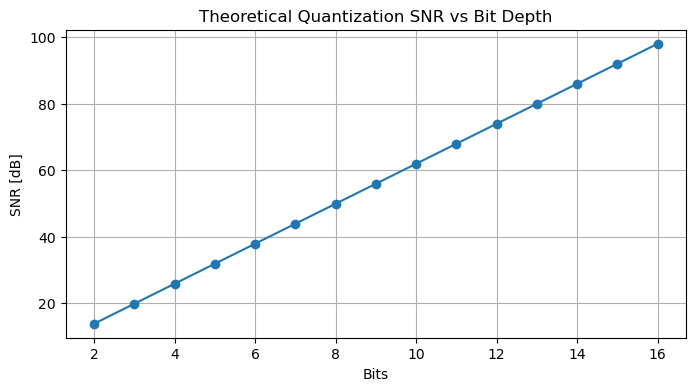

In [4]:
bits = np.arange(2, 17)
snr = 6.02*bits + 1.76

plt.figure(figsize=(8,4))
plt.plot(bits, snr, 'o-')
plt.xlabel('Bits')
plt.ylabel('SNR [dB]')
plt.title('Theoretical Quantization SNR vs Bit Depth')
plt.grid()
plt.show()

## 4. ADC Architectures

Different ADC designs balance **speed, resolution, and complexity**.  
Here are three common architectures:

---

### Flash ADC
- **Architecture:**  
  - A bank of \(2^n - 1\) comparators connected to a resistor ladder reference.  
  - Each comparator checks if the input voltage is above or below its threshold.  
  - Outputs form a **thermometer code**, then a priority encoder converts this to binary.  

- **Operation:**  
  - Conversion in **one step** → extremely fast.  
  - Output changes instantly when input crosses comparator thresholds.  
  - Hardware cost is high: for 8 bits, needs 255 comparators.  

- **Applications:**  
  High-speed oscilloscopes, RF digitizers, ultra-fast systems.  

- **Learn more:**  
  - [Flash ADC Tutorial (AllAboutCircuits)](https://www.allaboutcircuits.com/textbook/digital/chpt-13/flash-adc/)  
---

### SAR (Successive Approximation Register) ADC
- **Architecture:**  
  - Contains a DAC, a comparator, and a successive-approximation register.  
  - DAC generates trial voltages which are compared with the input.  
  - Each bit is decided in sequence (binary search).  

- **Operation:**  
  1. Set MSB = 1 → DAC produces mid-scale voltage.  
  2. Comparator decides if input is above or below.  
  3. Keep or clear MSB, then move to the next bit.  
  4. Repeat until LSB is resolved.  
  - An \(n\)-bit conversion requires **n steps**.  

- **Applications:**  
  Microcontrollers, general-purpose ADCs, medium-speed data acquisition.  

- **Learn more:**  
  - [SAR ADC Basics (Analog Devices)](https://www.analog.com/en/resources/technical-articles/successive-approximation-registers-sar-and-flash-adcs.html)   

---

### Sigma-Delta (ΔΣ) ADC
- **Architecture:**  
  - Integrator + 1-bit quantizer (comparator) + feedback loop.  
  - Produces a **high-frequency bitstream** instead of direct binary output.  
  - A digital filter and decimator convert the bitstream into a high-resolution output.  

- **Operation:**  
  - **Oversampling:** input is sampled much faster than Nyquist.  
  - **Noise shaping:** pushes quantization noise to higher frequencies.  
  - Digital filtering removes out-of-band noise → precise low-bandwidth result.  

- **Applications:**  
  Precision audio ADCs, instrumentation, industrial sensors.  

- **Learn more:**  
  - [Sigma-Delta ADC Simulator (Analog)](https://www.analog.com/en/resources/interactive-design-tools/sigma-delta-adc-tutorial.html?utm_source=chatgpt.com)  

---


## 5. Exercise

A microcontroller has a 12-bit ADC with a 3.3 V reference.

- What is the voltage resolution per step?
- What is the theoretical SNR?
- Compare to datasheet values for a real MCU ADC.

### Voltage Resolution

The ADC splits the input range (0 to reference voltage) into small steps.  
The smallest change it can detect is called **voltage resolution** or quantization step ($\Delta$).

$$ \Delta = \frac{V_{ref}}{2^n} $$

Where:  
- $V_{ref}$ = reference voltage  
- $n$ = number of bits  

For a 12-bit ADC with $V_{ref} = 3.3 \,\text{V}$:  

$$ \Delta = \frac{3.3}{2^{12}} = \frac{3.3}{4096} \approx 0.000806 \,\text{V} \approx 0.806 \,\text{mV}$$


### Theoretical SNR

When we digitize a signal with an $n$-bit ADC, quantization introduces noise.  
The Signal-to-Noise Ratio (SNR) for an ideal ADC can be approximated as:

$$ SNR \approx 6.02 \cdot n + 1.76 \,\text{dB} $$

- Each additional bit improves SNR by about **6 dB**.  
- So, higher resolution (more bits) → less quantization noise and better signal quality.

For a 12-bit ADC:

$$ SNR \approx 6.02 \cdot 12 + 1.76 = 74 \,\text{dB} $$

### Comparison with real MCU ADC (Analog Devices AD7883)

📄 [AD7883 datasheet](https://www.analog.com/media/en/technical-documentation/data-sheets/AD7883.pdf)

| Parameter            | Theoretical (calculated)         | Datasheet (AD7883)              | Page                        |
|----------------------|----------------------------------|---------------------------------|-----------------------------|
| Resolution           | 12 bits (assumed in task)        | 12 bits                         | p.2 (*DC Accuracy*)         |
| Voltage Resolution   | Δ = 3.3 V / 4096 ≈ **0.806 mV**  | 1 LSB = **0.8 mV** (Vref=3.3 V) | p.6                         |
| SNR                  | **74 dB** (formula: 6.02·n+1.76) | **71 dB** (typical)             | p.2 (*Dynamic Performance*) |

The theoretical calculations match very closely with the real datasheet values.  
- The voltage resolution differs only by rounding (0.806 mV vs 0.8 mV).  
- For SNR, theory says 74 dB, but the real chip has about 71 dB → the small difference comes from real-world imperfections.